# Machine Learning Problem Set #2: Discriminative and Generative Classifiers

In this problem set, you will explore discriminative and generative classifiers.

## Problem 1: Generate an interesting data set

In class, we considered a synthetic problem in which a training data set was sampled from two classes. In this problem, you will generate a data set with similar characteristics to the dataset discussed in class.

**Class 1:** Two features $x_1$ and $x_2$ jointly distributed as a two-dimensional spherical Gaussian with parameters

$$\mu = \begin{bmatrix} x_{1c} \\ x_{2c} \end{bmatrix},
\Sigma = \begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_1^2 \end{bmatrix}.$$

**Class 2:** Two features $x_1$ and $x_2$ in which the data are generated by first sampling an angle $\theta$ according to a uniform distribution, sampling a distance $d$ according to a one-dimensional Gaussian with a mean of $(3\sigma_1)^2$ and a variance of $(\frac{1}{2}\sigma_1)^2$, then outputting the point $$\textbf{x} = \begin{bmatrix} x_{1c} + d \cos\theta \\ x_{2c} + d \sin\theta \end{bmatrix}$$.

Place your code to generate 100 samples from the each of the classes and plot them in the cell below.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [2]:
mu_1 = np.array([1.0, 3.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)

X2 = np.matrix([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

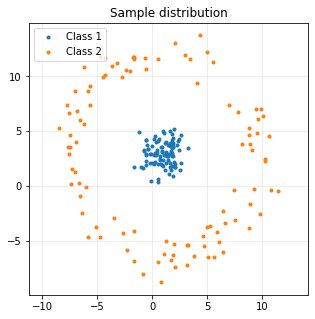

In [3]:
fig2 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample distribution')
plt.grid(axis='both', alpha=.25)
plt.plot(X1[:,0],X1[:,1],'.', label = 'Class 1')
plt.plot(X2[:,0],X2[:,1],'.', label = 'Class 2')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

## Problem 2: Discriminative classification with logistic regression

Split the dataset into 80 patterns per class for training and 20 patterns per class for
validation/testing.

Perform three experiments with logistic regression: batch gradient ascent on the log likelihood,
stochastic gradient ascent on the log likelihood, and batch Newton's method.

For each method, plot log likelihood and classification accuracy on the test set and
training set as a function of iteration (one batch or pass through the training set per iteration).

After showing your code and results, in the cell(s) below, briefly discuss your results. Are all
three methods converging to the same maximum? Is the Hessian always invertible? Plot the test data
and decision boundary for at least one of the solutions.


In [4]:
X = np.concatenate([X1, X2],axis = 0);
y = np.concatenate([-np.matrix(np.ones([100,1])),np.matrix(np.ones([100,1]))]);

In [5]:
M, N = X.shape
alpha = 0.0001
theta = np.ones((3,1))
#theta = np.ones((3,1))
XX = np.concatenate((np.ones([M,1]), X),1)

In [ ]:
XX = np.concatenate((np.ones([M,1]), X),1)
yy = y.copy()
yy[yy<0] = 0

In [6]:
def logistic_regression(theta, X, y, iterations):
    acc_best = 0
    theta_best = theta
    for i in range(0,iterations):
        y_pred = (1/(1+np.exp(-theta.T * XX.T))).T
        y_pred[y_pred<0.01] = 0.01
        y_pred[y_pred>0.99] = 0.99
        loglike = sum(np.multiply(yy,np.log(y_pred))+np.multiply(1-yy,np.log(1-y_pred)))
        pred = np.ones((M,1))
        pred[y_pred < 0.5] = 0
        corr = pred == yy
        acc = sum(corr)[0,0]/M
        #print('Iter %d: log likelihood %f accuracy %f' % (i, loglike, acc))
        if acc > acc_best:
            theta_best = theta
            acc_best = acc
        order = np.random.permutation(range(0,M))
        num_corr = 0
        for j in range(0,M):
            x = XX[order[j],:].T
            y_actual = yy[order[j],0]
            y_pred = 1/(1+np.exp(-theta.T * x))
            y_pred = y_pred[0,0]
            gradient = (y_actual - y_pred) * x
            theta = theta + alpha * gradient
            if (y_pred >= 0.5 and y_actual == 1) or (y_pred < 0.5 and y_actual == 0):
                num_corr = num_corr + 1
    print("Optimal theta: [%f %f %f]" % (theta_best[0], theta_best[1], theta_best[2]))    
    print("Accuracy of optimal theta: %f" % acc_best)
    return theta_best, acc_best

def plot_data(X1,X2):
    series1 = plt.scatter(np.array(X1[:,0]), np.array(X1[:,1]), s=30, c='b', marker='o', label='Class 1')
    series2 = plt.scatter(np.array(X2[:,0]), np.array(X2[:,1]), s=30, c='y', marker='o', label='Class 2')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Data')
    plt.legend(handles=[series1, series2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [7]:
logistic_regression(theta, XX, yy,200)

Optimal theta: [0.727469 -0.008692 -0.084136]
Accuracy of optimal theta: 0.385000


(matrix([[ 0.72746939],
         [-0.00869178],
         [-0.08413645]]), 0.385)

In [8]:
def hessian_matrix(theta, X):
    m = len(X)
    y_pred = (1/(1+np.exp(-theta.T * XX.T))).T    
    y_pred[y_pred<0.01] = 0.01
    y_pred[y_pred>0.99] = 0.99
    d = np.multiply(y_pred ,(1 - y_pred))
    d = d.reshape(y_pred.shape[0],)
    d = np.array(d.tolist()[0])
    R=np.diag(d)
    gradient = 1/m * np.dot(X.transpose(),(y - y_pred))
    return (X.T * R) * X, gradient, y_pred
  
logistic_regression(theta, XX, yy,20)

def newton_method(theta, X, y,  alpha, numIter):
    acc_best = 0
    theta_best = theta
    for i in range(numIter):
        hessian, gradient, y_pred = hessian_matrix(theta, XX)
        loglike = sum(np.multiply(yy,np.log(y_pred))+np.multiply(1-yy,np.log(1-y_pred)))
        hessian_inv = np.linalg.inv(hessian)
        theta = theta + hessian_inv @ gradient
        pred = np.ones((M,1))
        pred[y_pred < 0.5] = 0
        corr = pred == yy
        acc = sum(corr)[0,0]/M        
        print('Iter %d: log likelihood %f accuracy %f' % (i, loglike, acc))
        print(theta)
        if acc > acc_best:
            theta_best = theta
            acc_best = acc
    return theta_best, acc_best


Optimal theta: [1.000000 1.000000 1.000000]
Accuracy of optimal theta: 0.325000


In [9]:

# Train test data sets


#idx = np.arange(0,len(X),1)
#np.random.shuffle(idx)
#idx_train = idx[0:int(.8*len(X))]
#idx_test = idx[len(idx_train):len(idx)]


#X_train = X[idx_train]
#X_test = X[idx_test]
#X_train = np.concatenate([np.ones((X_train.shape[0], 1)),X_train], 1)
#X_test = np.concatenate([np.ones((X_test.shape[0], 1)),X_test], 1)

#y_train = y[idx_train]
#y_test = y[idx_test]





num_train_set = int(0.8 * num_sample)
num_test_set = num_sample - num_train_set

X_train = np.concatenate([X1[:num_train_set, :], X2[:num_train_set, :]], 0)
X_test = np.concatenate([X1[num_train_set:, :], X2[num_train_set:, :]], 0)
X_train = np.concatenate([np.ones((X_train.shape[0], 1)),X_train], 1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1)),X_test], 1)

y_train = np.concatenate([np.zeros((num_train_set, 1)),np.ones((num_train_set, 1))], 0)
y_test = np.concatenate([np.zeros((num_test_set, 1)), np.ones((num_test_set, 1))], 0)

X1_train = X_train[:num_train_set, :]
X2_train = X_train[num_train_set:, :]

## Problem 3: Transformation of the feature space

Perform a polar transform on the data and re-run one of your logistic regression models (whichever you prefer).
As before, plot the log likelihood and accuracy on the training set and test set as a function of iteration.

Comment on your results. Obviously, this is an example contrived to illustrate the importance of data representation
and how much of a difference a simple transformation of the feature space can make. But can you think of some
real world problems that would be similarly difficult?


In [85]:
def polar_transform(X):
    mu = np.mean(X[:, 1:], axis=0).T
    #r = np.sqrt((X[:, 1] - mu[0])**2 + (X[:, 2] - mu[1])**2).reshape((X.shape[0], 1))
    rad = np.sqrt(np.power((X[:, 0] - mu[0]),2) + np.power((X[:, 1] - mu[1]),2))
    t = np.arctan2(X[:, 2] - mu[1],X[:, 1] - mu[0]).reshape((X.shape[0], 1))
    return np.concatenate([rad, t], 1)

def polar_transform1(X):
    mu = np.mean(X[:, 1:], axis=0).T
    #r = np.sqrt((X[:, 1] - mu[0])**2 + (X[:, 2] - mu[1])**2).reshape((X.shape[0], 1))
    rad = np.array([np.sqrt(np.power((X[:, 0] - mu[0]),2) + np.power((X[:, 1] - mu[1]),2))])
    t = np.arctan2(X[:, 2] - mu[1],X[:, 1] - mu[0]).reshape((X.shape[0], 1))
    return np.concatenate([rad.T, t], 1)

In [86]:
X_train_polar = polar_transform(X_train)
X_test_polar = polar_transform(X_test)

logistic_regression(theta, X_train_polar, y_train,200)
logistic_regression(theta, X_test_polar, y_test,200)



Optimal theta: [0.810794 0.125201 -0.066590]
Accuracy of optimal theta: 0.375000
Optimal theta: [0.810801 0.125317 -0.066603]
Accuracy of optimal theta: 0.375000


(matrix([[ 0.8108009 ],
         [ 0.12531655],
         [-0.06660301]]), 0.375)

In [87]:
XX1 = np.concatenate((np.ones([len(X1),1]), X1),1)
XX2 = np.concatenate((np.ones([len(X2),1]), X2),1)
XX1_polar = polar_transform1(XX1)
XX2_polar = polar_transform(XX2)

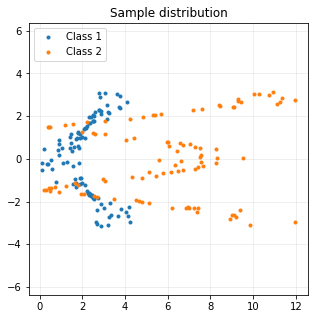

In [88]:
fig3 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample distribution')
plt.grid(axis='both', alpha=.25)
plt.plot(XX1_polar[:,0],XX1_polar[:,1],'.', label = 'Class 1')
plt.plot(XX2_polar[:,0],XX2_polar[:,1],'.', label = 'Class 2')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

## Problem 4: Derive maximum likelihood parameter estimation method

We already know that the maximum likelihood estimates of the mean and covariance of the
Gaussian-distributed class are the mean and covariance of the sample. But let's derive
a maximum likelihood estimator for the parameters of the second class.

In class, we outlined a procedure for estimating the parameters $x_{1c}$, $x_{2c}$, $r$, and $\sigma$ of
a generative model for points in the annulus shaped class. Complete the exercise. What are the maximum likelihood
estimates of the four parameters for a particular data set?


## Problem 5: Generative classifier

Based on the parameter estimation method you derived in Problem 4, build a maximum a posteriori classifier for the data based on the generative model
$$p(y \mid \textbf{x}) \propto p(\textbf{x} \mid y) p(y).$$
Show your results and compare to the results of Problems 2 and 3. Which approach is best for this data set?

Here we append the data from two class, class 0 and class 1.

All the points are bivariate Gaussian distributed  where class 1 has same mean as class 0 where each data point in class 1 is extended by distance d and rotated by angle.

Compute mean and sigma based on MLE calculations as shown in tutorial session

In [89]:
X_append = np.append(X1,X2, axis = 0)
sigma_mle = np.sqrt(np.sum(np.square(X_append[:,0] - X_append[:,0].mean()) + np.square(X_append[:,1] - X_append[:,1].mean()))/M)
cov_mle = np.matrix([[sigma_mle**2, 0],[0, sigma_mle**2]])
mu_mle = np.array([X_append[:,0].mean(), X_append[:,1].mean()])


Compute joint probability

In [90]:
gaussian_prob = np.array(np.exp(np.square(X_append - mu_mle)*np.linalg.inv(cov_mle)/(-2)))
p_class0 = len(X1)/len(X_append)
p_class1 = len(X2)/len(X_append)
gaussian_prob_joint = np.array([(gaussian_prob[:,0]*p_class0)* (gaussian_prob[:,1]*p_class1)])
gaussian_prob_joint = np.concatenate((np.array([gaussian_prob[:,0]* gaussian_prob[:,1]]).T,yy), axis = 1)

Estimate decision boundry point

In [91]:
gaussian_class0 = gaussian_prob_joint[np.where(gaussian_prob_joint[:,1] == 0)].T
decision_boundry_prob = gaussian_class0[np.argmin(gaussian_class0)]
decision_boundry_pt = X_append[np.argmin(gaussian_class0)]
#print(decision_boundry_pt)


Plot decision boundry point

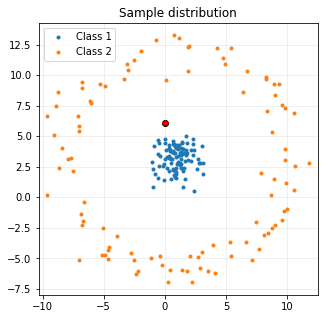

In [92]:
fig2 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample distribution')
plt.grid(axis='both', alpha=.25)
plt.plot(X1[:,0],X1[:,1],'.', label = 'Class 1')
plt.plot(X2[:,0],X2[:,1],'.', label = 'Class 2')
plt.plot(decision_boundry_pt[:,0],decision_boundry_pt[:,1],'ko')
plt.plot(decision_boundry_pt[:,0],decision_boundry_pt[:,1],'r*')
plt.plot()
plt.legend(loc=2)
plt.axis('equal')
plt.show()

Estimate decision boundry

In [93]:
angle = np.random.uniform(0, 2*np.pi, num_sample*3)
angle_boundry_pt = np.arctan2(decision_boundry_pt[:,1],decision_boundry_pt[:,0])
radius_boundry = decision_boundry_pt[:,0]/np.cos(angle_boundry_pt)
x_boundry = radius_boundry*np.cos(angle)
y_boundry = radius_boundry*np.sin(angle)

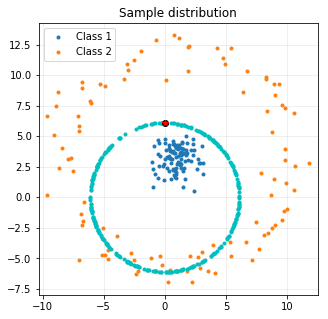

In [94]:
fig3 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample distribution')
plt.grid(axis='both', alpha=.25)
plt.plot(X1[:,0],X1[:,1],'.', label = 'Class 1')
plt.plot(X2[:,0],X2[:,1],'.', label = 'Class 2')
plt.plot(x_boundry,y_boundry,'c.')
plt.plot(decision_boundry_pt[:,0],decision_boundry_pt[:,1],'ko')
plt.plot(decision_boundry_pt[:,0],decision_boundry_pt[:,1],'r*')
plt.plot()
plt.legend(loc=2)
plt.axis('equal')
plt.show()

In [95]:
angle_X_append = np.arctan2(X_append[:,1],X_append[:,0])
X_distance_mle = X_append[:,0]/np.cos(angle_X_append)
x_boundry = radius_boundry*np.cos(angle)
y_boundry = radius_boundry*np.sin(angle)
y_pred_mle = gaussian_prob_joint[:,0]
pred_mle = np.ones((M,1))
pred_mle[X_distance_mle < radius_boundry] = 0
corr_mle = pred_mle == yy
acc_mle = sum(corr_mle)[0,0]/M
print('Accuracy ', acc_mle)

Accuracy  0.93
